In [2]:

import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
path_source_code = ''
import os
import sys
sys.path.append(path_source_code) # Replace with the actual path to the directory containing pdf_preprosseing.py
from pre_processing import get_only_words_from_strings, remove_stop_words, extract_entities, hash_content, correct_text,plot_filenames_for_entity
from tqdm import tqdm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Jaque\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Jaque\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Jaque\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Jaque\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Jaque\AppData\Roaming\nltk_data...
[

https://paperswithcode.com/dataset/justice#
The dataset contains 3304 cases from the Supreme Court of the United States from 1955 to 2021. Each case has the case's identifiers as well as the facts of the case and the decision outcome.

In [4]:
##Data cleaning and preparation 
file_path = os.path.join(path_source_code, "modern_slavery_ENTITIES_related.csv")
file_path2 = os.path.join(path_source_code, "modern_slavery_NER.csv")
if not (os.path.exists(file_path) and os.path.exists(file_path2)):
    #Read datasources and redefine schema
    df2 = pd.read_csv("clean_data.csv",index_col=0)
    df2['hash'] = df2.facts.apply(hash_content)
    df2['content'] = df2['facts'].astype(str).str.lower().apply(get_only_words_from_strings)
    df2["source"] = 'https://paperswithcode.com/dataset/justice'
    df2["target"] = 0

    df = pd.read_csv("modern_slavery_cases2.csv",index_col=0)
    df= df[["filename","content"]]
    df['hash'] = df.content.apply(hash_content)
    df.rename(columns={'filename': 'name'}, inplace=True)
    df["target"] = 1
    df["source"] = 'self'

    #Concat data from diverse datasources
    df = pd.concat([df,df2])


    #before any corrections
    #find e-mail patterns and replace for [EMAIL]
    df['email'] = df['content'].apply(find_emails)
    df['links'] = df['content_no_entity'].apply(find_links)
    
    #remove duplicates
    df['links'] = df['links'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['links'] = df['links'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    df['email'] = df['email'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['email'] = df['email'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    
    #input placeholders
    unique_emails = extract_unique_values(df, 'email')
    df['content_no_entity'] = df['content'].apply(lambda x: replace_entity(x, unique_emails, "[[EMAIL]]"))
    unique_links = extract_unique_values(df, 'links')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_links, "[[LINK]]"))
    unique_links2 =[extract_radical(url) for url in unique_links]
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_links2, "[[LINK]]"))
#----

    #Before remove numbers
    df['date'] = df['content_no_entity'].apply(
        lambda text: extract_entities(text, labelset=("DATE"))
    )

    df['date'] = df['date'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['date'] = df['date'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    unique_date = extract_unique_values(df, 'date')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_date, "[[DATE]]"))


    #remove all pontuation keep only slash and dot
    df['content_no_entity'] = df['content_no_entity'].apply(
        lambda x: re.sub(r'[{}]'.format(re.escape(string.punctuation.replace('/', '').replace('.', ''))), '', x) 
        if isinstance(x, str) else x)

    df['content_no_entity'] = df.content_no_entity.apply(remove_numbers)

    df['org'] = df['org'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['org'] = df['content_no_entity'].apply(
        lambda text: extract_entities(text, labelset=("ORG"))
    )
  
    unique_org = extract_unique_values(df, 'org')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_org, "[[ORG]]"))


    df['person'] = df['person'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['person'] = df['person'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    unique_persons = extract_unique_values(df, 'person')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_persons, "[[PERSON]]"))


    df['location'] = df['content_no_entity'].apply(
        lambda text: extract_entities(text, labelset=("LOC"))
    )
    df['location'] = df['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['location'] = df['location'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    unique_location = extract_unique_values(df, 'location')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_location, "[[LOCATION]]"))



    df['GPE'] = df['content_no_entity'].apply(
        lambda text: extract_entities(text, labelset=("GPE"))
    )
    df['GPE'] = df['GPE'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    df['GPE'] = df['GPE'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    unique_GPE= extract_unique_values(df, 'GPE')
    df['content_no_entity'] = df['content_no_entity'].apply(lambda x: replace_entity(x, unique_GPE, "[[GPE]]"))
    #Remove numbers, correct segmented and misspelled words, remove stop words
    df['content_corrected'] = df.content_no_entity.apply(detect_words_segment)
    df['content_corrected'] = df['content_corrected'].astype(str).str.lower().apply(correct_text)

    custom_stop_words = ['cv','th','id','page','cir','fd','pageid','fileid','cvngclp', 'cvjfbarl','case','document', 'cid', 'usc', 'th cir', 'fd th', 'wl', 'file page','http','www']
    df['content_corrected'] = df['content_corrected'].astype(str).str.lower().apply(lambda text: remove_stop_words(text,custom_stop_words))
    df.to_csv("modern_slavery_NER.csv", index=False)

    # 🔹 Step 1: Convert list columns into a long format using `melt`
    df_melted = df.melt(id_vars=['name', 'hash'], value_vars=['location', 'org', 'person', 'date', 'email', 'links', 'GPE'], var_name='entity_type', value_name='entity')

    # 🔹 Step 2: Explode the 'entity' column (previously stored as lists)
    df_melted['entity'] = df_melted['entity'].apply(lambda x: x if isinstance(x, list) else [x])
    df_melted['entity'] = df_melted['entity'].apply(ast.literal_eval)
    df_exploded = df_melted.explode('entity', ignore_index=True)
    df_exploded = df_exploded[df_exploded["entity"].astype(str) != "[]"]
    df_exploded.to_csv('modern_slavery_ENTITIES_related.csv')

else:
    print("A file " + str(file_path) + ' is already placed at this path')
    df = pd.read_csv('modern_slavery_ENTITIES_related.csv',index_col =0 )
    df = df.drop_duplicates()


A file modern_slavery_ENTITIES_related.csv is already placed at this path


In [10]:
df.dropna().to_csv("Modern_Salvery_NER_20_03_2025.csv")

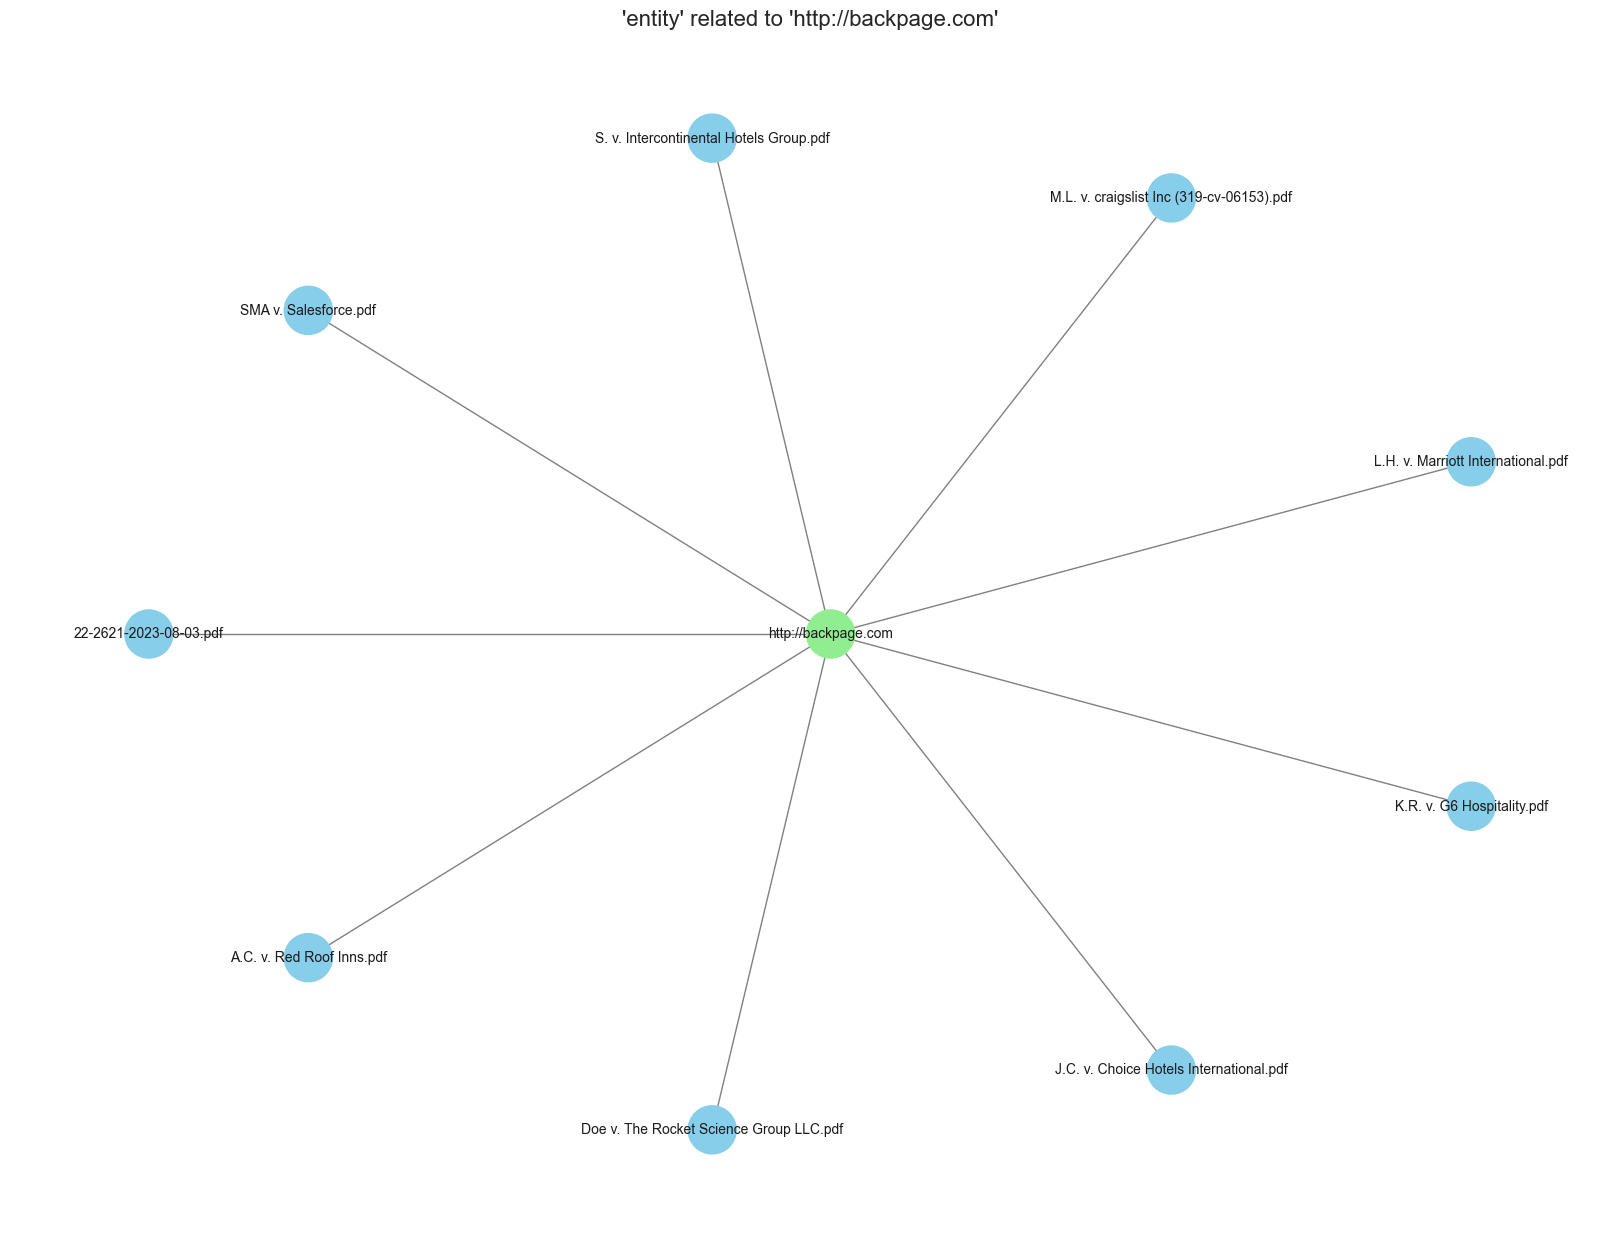

In [66]:

plot_filenames_for_entity("http://backpage.com", df)

In [41]:
df[df['entity_type'] == "location"].head(50)

,name,hash,entity_type,entity
0,22-2621-2023-08-03.pdf,f0f02941aa3e73bfae0e2877fc3f29251429368abf6abd894d67f56be8a4ef19,location,the Northern District
1,A.B. v. WYNDHAM HOTEL.pdf,8bbd8a044e3398abe3a6d8f35956563e3f6f48b4236561c295a20165256e1d92,location,NaN
2,A.C. v. Red Roof Inns.pdf,823c076f4aac4713d441123d771a247494624dc2f9fea2502037826937311fc9,location,NaN
3,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Antarctic
4,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Western Central Pacific
5,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Central Pacific
6,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Wild
7,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Mt. Pleasant
8,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Southern Ocean Coalition
9,"Abdallah Nasser v. Bumble Bee Foods, LLC.pdf",00c8d718dccb2e94226af9d5e6e1d803d5ded08df0268717c7cb50987ec49df3,location,Europe


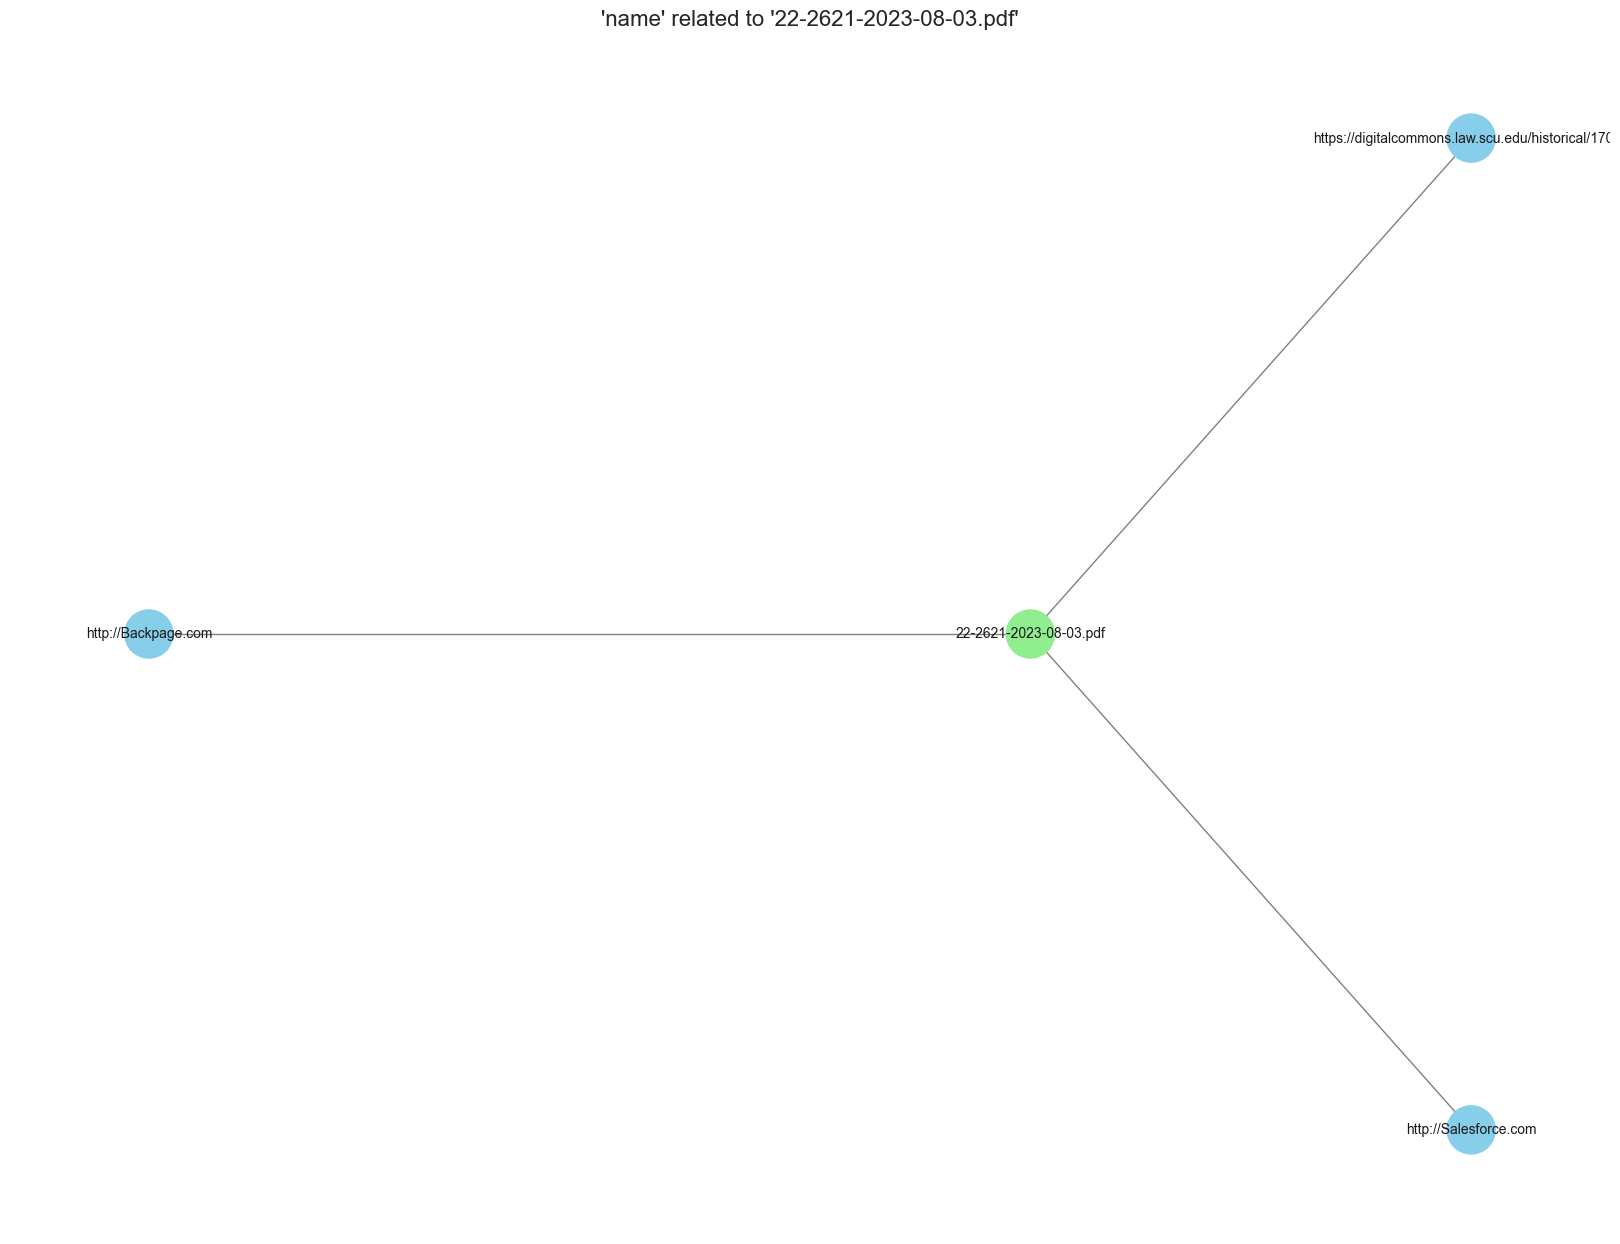

In [64]:

plot_filenames_for_entity("22-2621-2023-08-03.pdf",df[df.entity_type == "links"],entity_col='name', filename_col='entity')

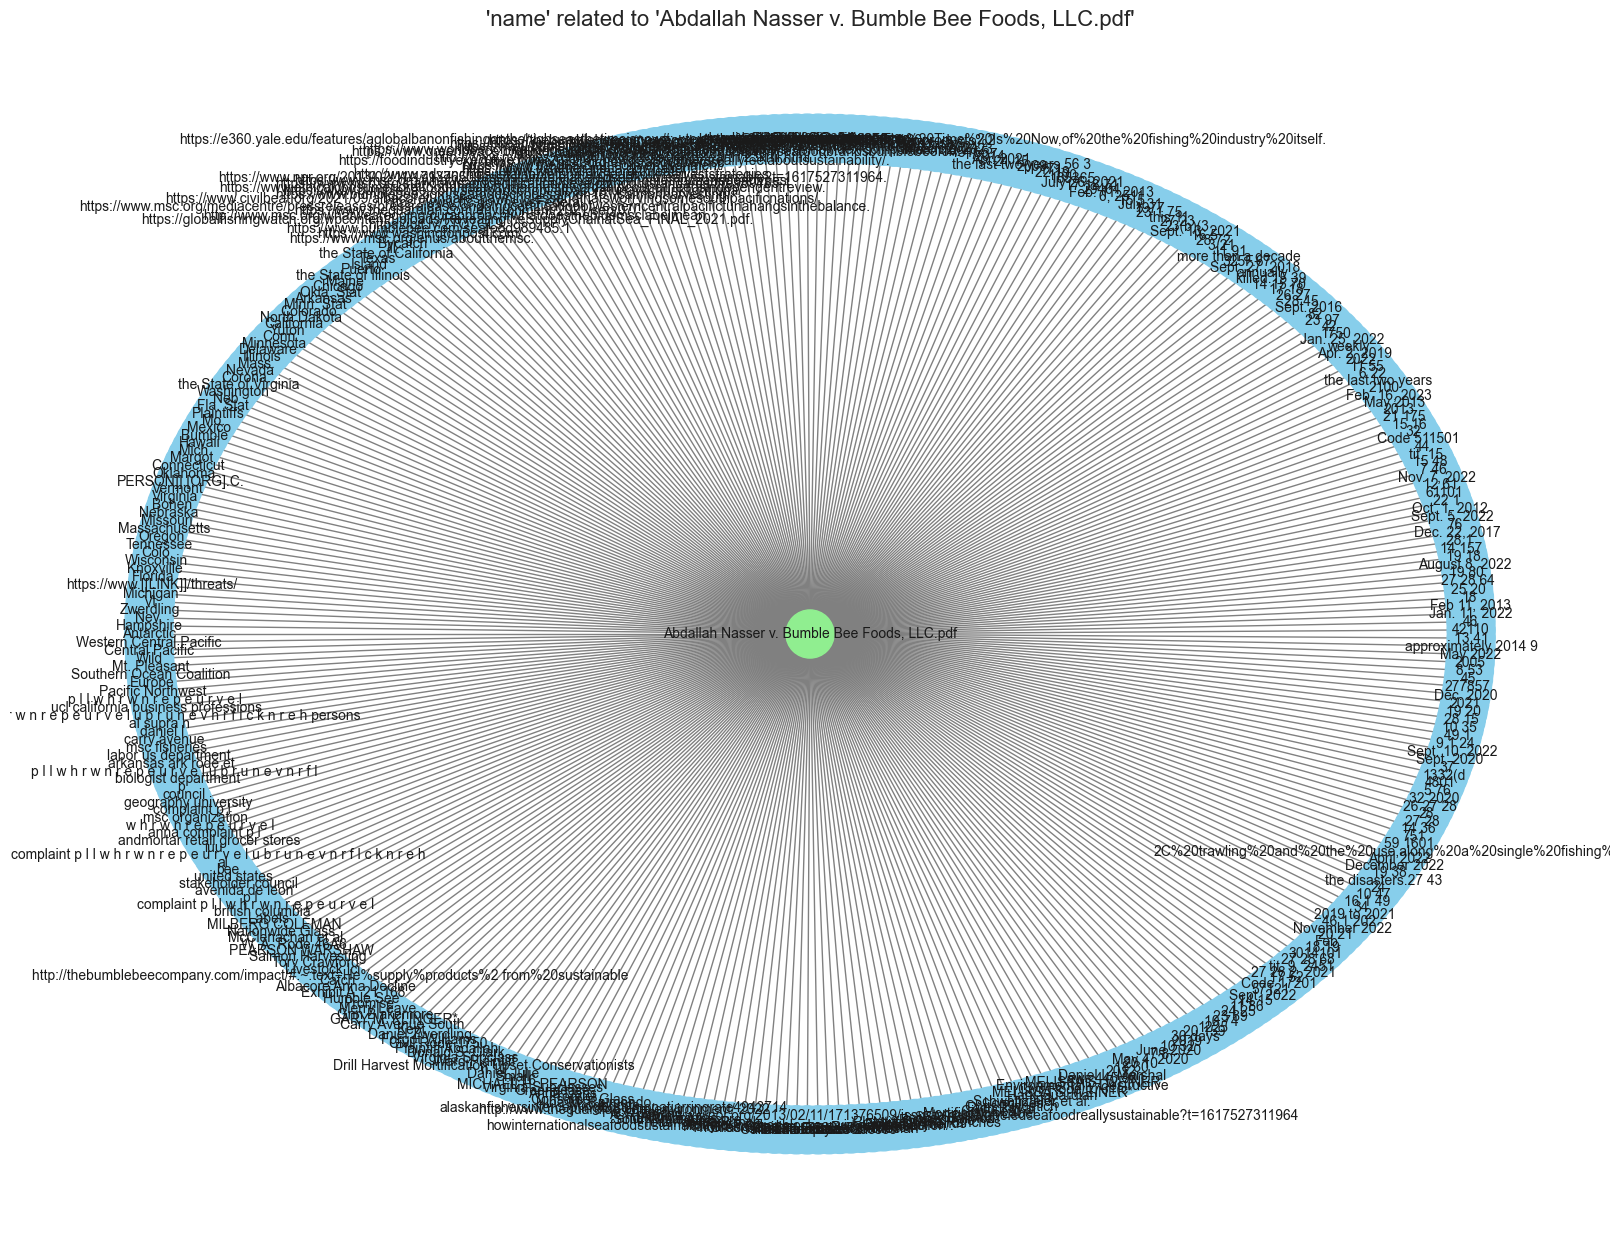

In [ ]:
plot_filenames_for_entity("Abdallah Nasser v. Bumble Bee Foods, LLC.pdf", df,entity_col='name', filename_col='entity')


In [41]:
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx
import matplotlib.pyplot as plt

def plot_entities_between(entity1, entity2, df, entity_type, entity_col='entity', 
                          filename_col='name', degree=2, title= "your plot"):
    """
    Plots a graph showing only the entities of a specific type that connect entity1 and entity2.

    :param entity1: The first named entity.
    :param entity2: The second named entity.
    :param df: A DataFrame containing entity and file relationships.
    :param entity_type: The specific entity type to focus on (e.g., 'organization', 'location').
    :param entity_col: Column containing entity names.
    :param filename_col: Column containing file names (or linking items).
    :param degree: How deep to search for indirect relations (default: 2).
    """
    # Create a graph
    G = nx.Graph()

    # Find files related to both entities
    files1 = set(df[df[entity_col].str.lower() == entity1.lower()][filename_col].dropna().unique())
    files2 = set(df[df[entity_col].str.lower() == entity2.lower()][filename_col].dropna().unique())

    # Find shared files between entity1 and entity2
    shared_files = files1 & files2
    if not shared_files:
        print(f"No direct file connection found between '{entity1}' and '{entity2}'.")
    
    # Entities of the given type connected via shared files
    relevant_entities = df[(df[filename_col].isin(shared_files)) & (df['entity_type'] == entity_type)][entity_col].dropna().unique()

    if len(relevant_entities) == 0:
        print(f"No '{entity_type}' entities found connecting '{entity1}' and '{entity2}'.")
        return
    
    # Add entity1, entity2, and relevant entities to the graph
    G.add_node(entity1, node_type='main_entity')
    G.add_node(entity2, node_type='main_entity')

    for entity in relevant_entities:
        G.add_node(entity, node_type='filtered_entity')
        for file in shared_files:
            if entity in df[df[filename_col] == file][entity_col].values:
                G.add_edge(entity, file)

    # Also add edges between entity1 and shared files, and entity2 and shared files
    for file in shared_files:
        G.add_node(file, node_type='file')
        if file in files1:
            G.add_edge(entity1, file)
        if file in files2:
            G.add_edge(entity2, file)

    # If degree > 1, expand search
    if degree > 1:
        second_degree_files = df[df[entity_col].isin(relevant_entities)][filename_col].dropna().unique()
        second_degree_files = [f for f in second_degree_files if f not in shared_files]

        second_degree_entities = df[(df[filename_col].isin(second_degree_files)) & (df['entity_type'] == entity_type)][entity_col].dropna().unique()

        for entity in second_degree_entities:
            if entity not in G.nodes():
                G.add_node(entity, node_type='filtered_entity')
            for file in second_degree_files:
                if entity in df[df[filename_col] == file][entity_col].values:
                    G.add_edge(entity, file)

    # Define layout
    pos = nx.spring_layout(G, seed=42)

    # Define node colors
    node_colors = [
        "red" if G.nodes[node]['node_type'] == 'main_entity' else 
        "lightgreen" if G.nodes[node]['node_type'] == 'filtered_entity' else 
        "skyblue" for node in G.nodes()
    ]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors,
        node_size=1200, font_size=10, edge_color='gray'
    )

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()



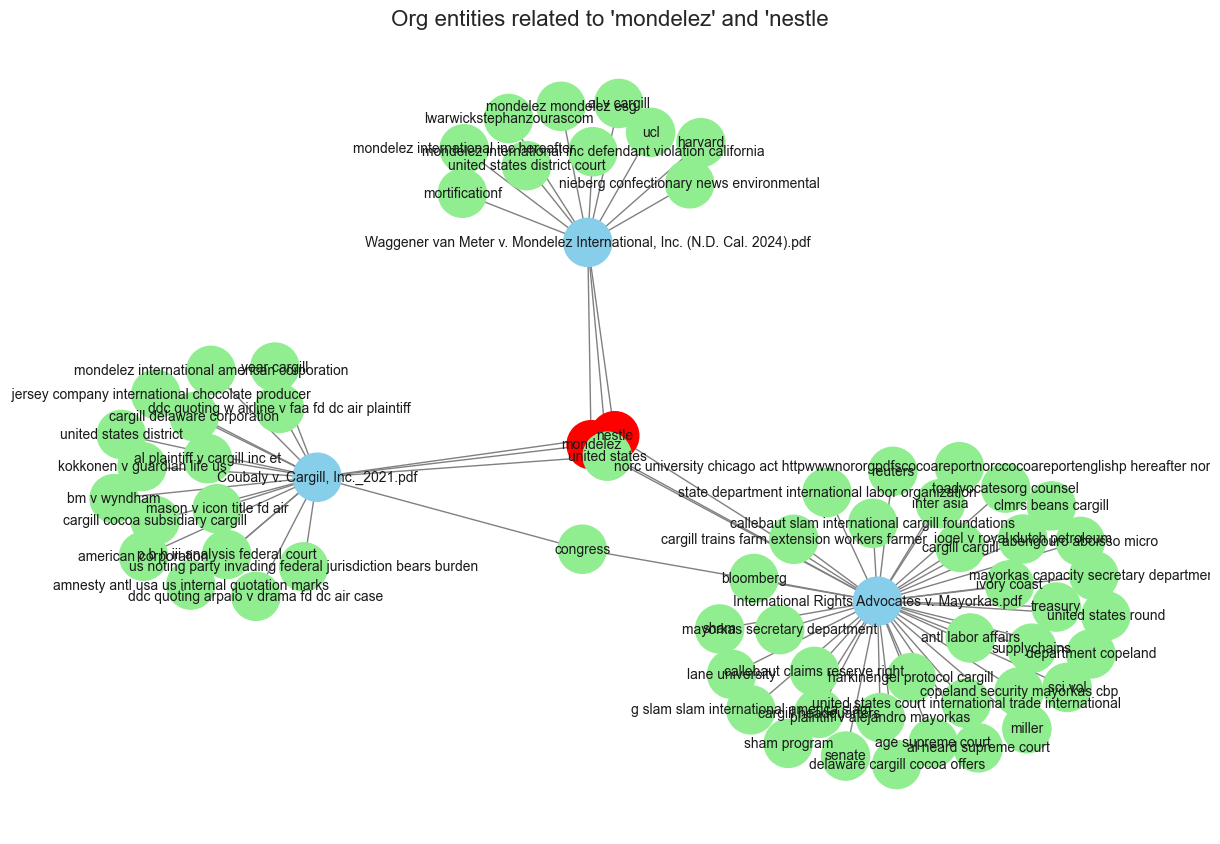

In [42]:
plot_entities_between("mondelez", "nestle", df, entity_type="org", degree=1, title = f"Org entities related to 'mondelez' and 'nestle")


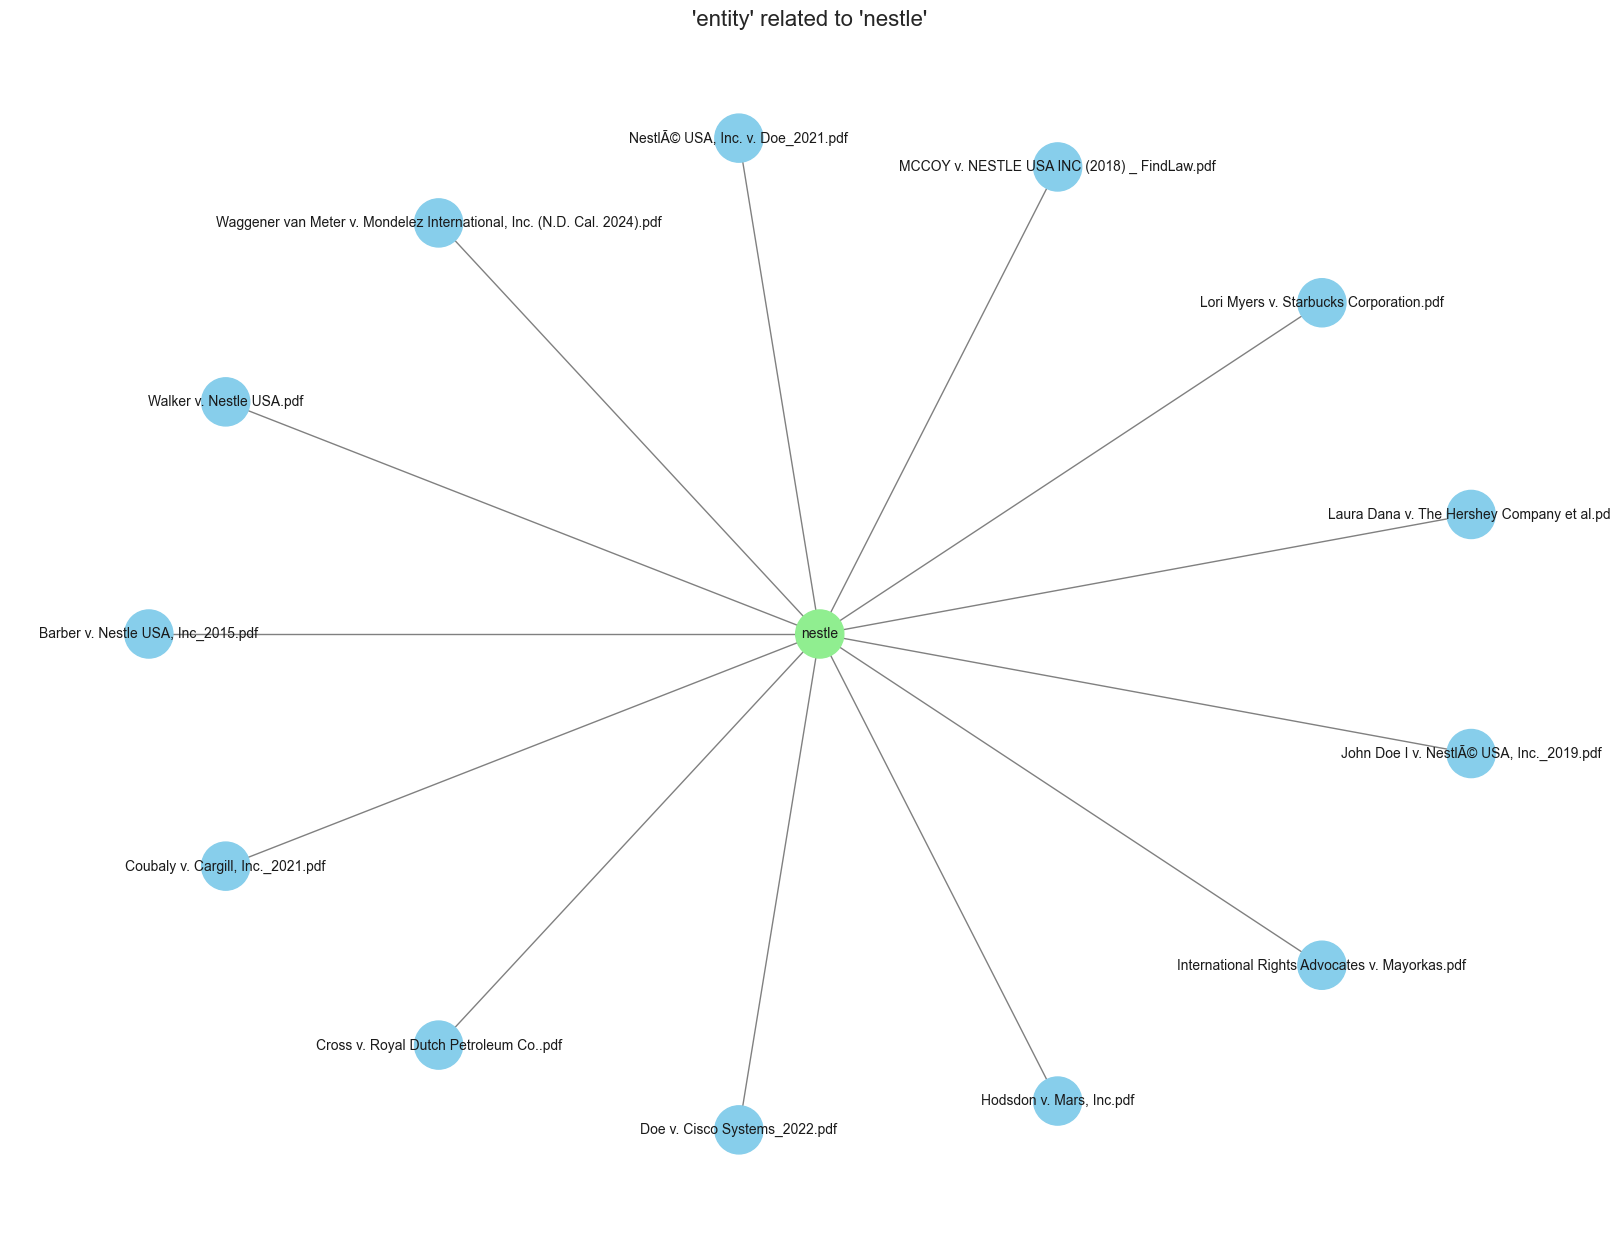

In [23]:
plot_filenames_for_entity("nestle", df,entity_col='entity', filename_col='name')